In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# train data

In [2]:
df = pd.read_csv('train.csv')
df = df.sort_values('timestamp')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [3]:
df.head()

,row_id,user_id,timestamp,gate_id
0,0,18,2022-07-29 09:08:54,7
1,1,18,2022-07-29 09:09:54,9
2,2,18,2022-07-29 09:09:54,9
3,3,18,2022-07-29 09:10:06,5
4,4,18,2022-07-29 09:10:08,5


In [4]:
df.shape

(37518, 4)

In [33]:
df['timestamp'].min(), df['timestamp'].max()

(Timestamp('2022-07-29 09:08:54'), Timestamp('2022-12-31 20:39:31'))

we have data for 4 months

In [38]:
df['user_id'].value_counts().tail(15)

28    64
45    57
7     49
36    48
2     39
8     29
10    17
38    13
5     10
30    10
52     5
21     5
44     4
51     3
4      2
Name: user_id, dtype: int64

In [43]:
df[df['user_id'] == 4]

,row_id,user_id,timestamp,gate_id
3505,3505,4,2022-08-09 10:09:08,8
3504,3504,4,2022-08-09 10:09:08,8


In [41]:
df[df['user_id'] == 44]

,row_id,user_id,timestamp,gate_id
36779,36779,44,2022-12-28 14:22:19,5
36780,36780,44,2022-12-28 14:22:21,5
36783,36783,44,2022-12-28 14:22:37,4
36784,36784,44,2022-12-28 14:22:39,4


In [42]:
df[df['user_id'] == 51]

,row_id,user_id,timestamp,gate_id
33465,33465,51,2022-12-13 13:30:11,3
34330,34330,51,2022-12-16 13:56:08,9
34331,34331,51,2022-12-16 13:56:08,9


some strange users, has small history

In [13]:
df['user_id'].unique()

array([18,  1,  3,  6, 29, 55, 24, 39, 47, 33,  0, 31, 37, 26, 50, 49, 53,
       20, 54, 19, 12, 46, 27, 25, 11, 15,  9, 48, 40, 56, 34, 22, 45, 23,
       57,  4,  8, 52, 32, 28,  7, 36, 42, 14, 35, 17,  5, 38, 41, 43, 10,
       51, 21, 30, 44,  2])

there is no user_id number 13,16

# test data

In [5]:
test = pd.read_csv('test.csv')
test = test.sort_values('timestamp')

In [6]:
test.head()

,row_id,timestamp,gate_id
0,37518,2023-01-03 08:21:00,9
1,37519,2023-01-03 08:21:00,9
2,37520,2023-01-03 08:21:18,5
3,37521,2023-01-03 08:21:19,5
4,37522,2023-01-03 08:21:39,10


In [7]:
test.shape

(7125, 3)

In [54]:
test['timestamp'].min(), test['timestamp'].max()

(Timestamp('2023-01-03 08:21:00'), Timestamp('2023-02-24 19:44:09'))

we need to predict next 2 months

# Compare train and test

In [20]:
gate_cnt_train = df['gate_id'].value_counts()
gate_cnt_test = test['gate_id'].value_counts()
gate_cnt_total = pd.concat([gate_cnt_train,gate_cnt_test], axis=1)
gate_cnt_total.columns = ['gate_cnt_train', 'gate_cnt_test']

In [27]:
gate_cnt_total

,gate_cnt_train,gate_cnt_test
4,8170.0,1459.0
3,5351.0,909.0
10,4767.0,915.0
5,4619.0,860.0
11,4090.0,762.0
9,3390.0,780.0
7,3026.0,540.0
6,1800.0,294.0
13,1201.0,345.0
12,698.0,132.0


* there is no gate_id in train number 2
* there is no gate_id in test number 0,16
* small values in gate_id -1, 8, 1, 16, 0, 14, 2

In [30]:
df[df['gate_id'] == 1]

,row_id,user_id,timestamp,gate_id
12650,12650,25,2022-09-06 11:16:22,1
12651,12651,25,2022-09-06 11:16:24,1
27897,27897,23,2022-11-05 10:04:27,1
27898,27898,23,2022-11-05 10:04:29,1
33581,33581,23,2022-12-14 09:09:34,1


in gate_id = 1, user_id = 25 or user_id = 23

In [31]:
df[df['gate_id'] == 14]

,row_id,user_id,timestamp,gate_id
35592,35592,12,2022-12-22 12:19:35,14


in gate_id = 14, user_id = 12

In [46]:
# create some simple features
def get_feats(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['second'] = df['timestamp'].dt.second
    df['date'] = df['timestamp'].apply(lambda x: str(x)[:10])
    df['day'] = df['timestamp'].dt.day
    df['dayofweek'] = df['timestamp'].dt.dayofweek     
    df['weekend'] = df['dayofweek'].isin([6,7]).astype('int')
    df['weekend'] = np.where(df['date'].isin(['2022-09-12','2022-11-25','2023-01-16']),1,df['weekend']) # holidays
       
    enc = OneHotEncoder()
    enc.fit(df[['dayofweek']])
    days = pd.DataFrame(enc.transform(df[['dayofweek']]).toarray())
    days.columns = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    days.index = df.index
    df = df.join(days)
    
    return df

In [48]:
df = get_feats(df)
test = get_feats(test)

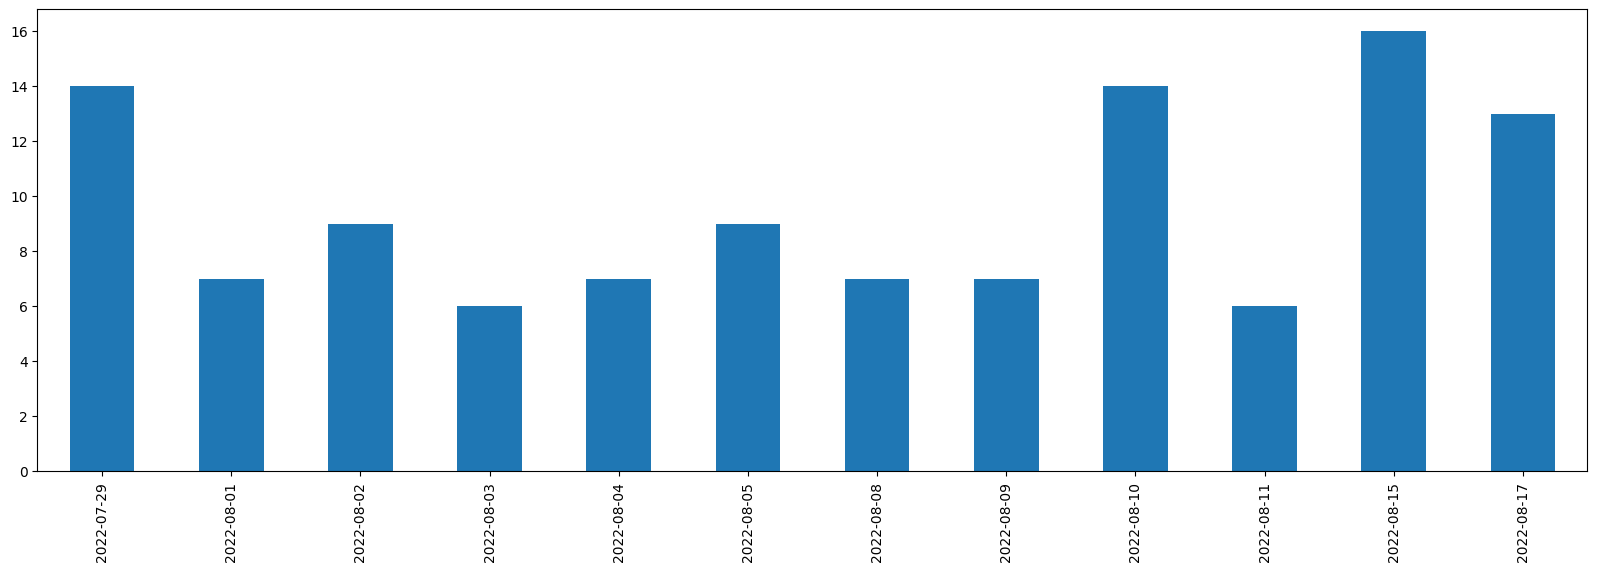

In [52]:
plt.figure(figsize=(20,6))
df[df['user_id'] == 20]['date'].value_counts().sort_index().plot(kind='bar');

There is users that has small history, or old history. Named their as wrong users :)

In [55]:
wrong_user = [4,5,7,8,10,20,21,30,31,38,40,42,44,45,51,52,57]

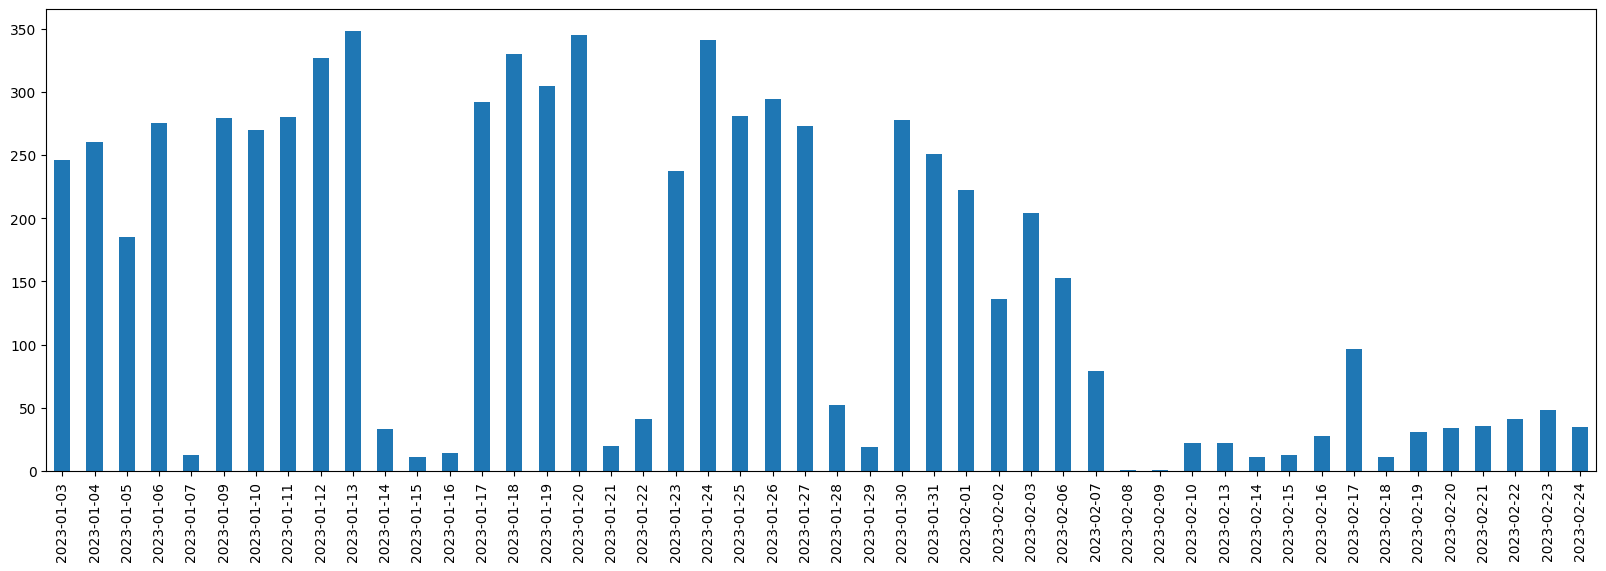

In [56]:
plt.figure(figsize=(20,6))
test['date'].value_counts().sort_index().plot(kind='bar');

Something strange was in February. Big holidays?

# Conclusions

* in gate_id = 14, user_id = 12
* in gate_id = 1, user_id = 25 or user_id = 23
* There is users that has small history, or old history - wrong_users -> drop them
* small counts was in February -> put it as weekend